# Scientific Python tutorial for the STAR collaboration

This notebook shows you how to do physics analysis in Python using a STAR PicoDST file. I presented it on Zoom on September 13, 2021.

You can read it in GitHub ([jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial)) or run it [interactively on Binder](FIXME).

I recommend the latter, as that would let you see the outputs of the code cells and make modifications to explore "what if?" scenarios. Binder loads all dependencies on its server; you don't have to install anything.

If you want to run it on your own computer, see the `requirements.txt` file for Python packages to install. The requirements specifies exact versions that are known to work with this notebook, but if you plan to use these libraries for other work, you'll probably want the latest versions of each.

This notebook is broken up into sections that lead toward a project in which you will be translating a C++ analysis into array-oriented Python.

## 1. Python: interactively building up an analysis

## 2. NumPy: thinking one array at a time

## 3. Uproot: array-oriented ROOT I/O

## 4. Awkward Array: complex data in arrays

## 5. Vector, hist, fastjet: the array-oriented ecosystem

## 6. Z peak: translating a C++ analysis into array-oriented Python

In this section, you will plot the mass of e⁺e⁻ pairs from the PicoDST file, using [star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C](star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C) as a guide.

### Reading the data

All data come from the PicoDST file, so let's load it again.

In [1]:
import uproot
import awkward as ak
import numpy as np

In [2]:
picodst = uproot.open("https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst")
picodst

<TTree 'PicoDst' (18 branches) at 0x7f327935c730>

In [star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C](star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C), the chain of commands that leads to getting a track is:

```c++
// get a reader and initialize it
const Char_t *inFile = "pythia_ppZee_run17emb.picoDst.root:PicoDst";
StPicoDstReader* picoReader = new StPicoDstReader(inFile);
picoReader->Init();

// in the loop over events (iEvent), load an event
Bool_t readEvent = picoReader->readPicoEvent(iEvent);
StPicoDst *dst = picoReader->picoDst();

// in the loop over tracks (iTrk), load a track
StPicoTrack *picoTrack = dst->track(iTrk);
```

The most relevant quantity for calculating invariant mass is the track's momentum:

```c++
picoTrack->pMom()
```

As a first step, we need to get track momenta. The [star-picodst-W-reference-for-jim/StPicoTrack.h](star-picodst-W-reference-for-jim/StPicoTrack.h) defines `pMom` as

```c++
TVector3 pMom() const           { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }
```

**Exercise 1:** Search through `picodst` and find _the full names_ of these branches. Then read all three into _arrays_ named `px`, `py`, and `pz`.

For reference, here is the [uproot.TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) documentation.

Depending on your network connection, those arrays could take 30 seconds to load. Be sure you have an expression that works on a small subsample before starting the big download.

In [ ]:
picodst. ???

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Search around with `picodst.keys`, gradually narrowing its output with wildcards or regular expressions like either of the following:

```python
picodst.keys(filter_name="*mPMomentum[XYZ]")

picodst.keys(filter_name="/.*mPMomentum[XYZ]/")
```
</details>

In [3]:
px, py, pz = ???

<details>
    <summary><b>Hint for postponing the big download</b> (okay, maybe peek)</summary>

Remember that all of the array-fetching functions (`TTree.arrays`, `TBranch.array`, etc.) take `entry_start` and `entry_stop` as arguments.

You can quickly limit the number of baskets read by setting `entry_stop` to some small number, like 1000.

```python
picodst.arrays("Event.mEventId", entry_stop=1000)
```
<br>

When you've got something you like, you can then remove the `entry_stop=1000` to let it go through the whole file.
</details>

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

There are several different ways to read the arrays, but the most straightforward are `TTree.arrays` and `TBranch.array`.

`TTree.arrays` can use the same `filter_name` that you identified with `TTree.keys`. But just calling it as-is returns a single array.

```python
single_array = picodst.arrays(filter_name="*mPMomentum[XYZ]")
```
<br>

**Solution 1:** You could, then, look at the `single_array.fields` ([ak.fields](https://awkward-array.readthedocs.io/en/latest/_auto/ak.fields.html)) to see what their names are and just pull them out.

```python
px = single_array["Track.mPMomentumX"]
py = single_array["Track.mPMomentumY"]
pz = single_array["Track.mPMomentumZ"]
```
<br>

**Solution 2:** Or you could pull them all out at once (without needing to know their names) with [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html).

```python
px, py, pz = ak.unzip(single_array)
```
<br>

**Solution 3:** Or, if you noticed the `how` parameter of `TTree.arrays`, you'd see that this gives you the desired form directly.

```python
px, py, pz = picodst.arrays(filter_name="*mPMomentum[XYZ]", how=tuple)
```
<br>

**Solution 4:** As one final alternative, you could get each branch object and use `TBranch.array` on each one individually. (For network traffic, this is three request-and-responses rather than one, so it's less efficient, but leave that for later performance tuning.)

```python
px = picodst["Track/Track.mPMomentumX"].array()
py = picodst["Track/Track.mPMomentumY"].array()
pz = picodst["Track/Track.mPMomentumZ"].array()
```
</details>

### Making an array of Lorentz vectors

Rather than calculating invariant mass from first principles, let's cast these as a `"Momentum4D"` with the Vector library.

In [4]:
import vector
vector.register_awkward()

**Exercise 2:** Combine the `px`, `py`, `pz`, and `M = 0.000511` (a constant) into an array of type

```
8004 * var * {"px": float32, "py": float32, "pz": float32, "M": float64}
```

It is _essential_ that the "`var`" is outside the record structure—that it is an array of lists of `px-py-pz-M` records, not an array of records of `px-py-pz-M` lists, such as

```
8004 * {"px": var * float32, "py": var * float32, "pz": var * float32, "M": float64}
```

_When that works,_ also add the name `"Momentum4D"` to those records, so that they become Lorentz vectors. The type should then look like

```
8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64]
```

Both of these should compute instantaneously. If it's taking a long time, something's wrong.

**Hint:** The [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) function is relevant. You might also use [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) and/or [ak.with_name](https://awkward-array.readthedocs.io/en/latest/_auto/ak.with_name.html), and [ak.type](https://awkward-array.readthedocs.io/en/latest/_auto/ak.type.html) or just `.type` to look at the type.

In [5]:
pMom = ???

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

This is just what the `ak.zip` function does, when given a dict of field names to arrays. Don't set the `depth_limit`, as that would prevent their merger into an array of lists of records. The `"M"` field does not need to be an array—`ak.zip` will "broadcast" a constant into the same shape as the other fields.

```python
ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511})
```
<br>

To add the `"Momentum4D"` name to these fields, you could use `ak.with_name` explicitly:

```python
ak.with_name(ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511}), "Momentum4D")
```
<br>

or just add it as an argument in the original `ak.zip`:

```python
ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511}, with_name="Momentum4D")
```
<br>

The `ak.Array` constructor also has a `with_name` argument, so you could have used that, too.
</details>

### Aside: if you're averse to physical constants in your code

There are libraries for that. Particle is a "Pythonic PDG" and hepunits has unit conversions in the same units as Particle.

In [6]:
import particle, hepunits

particle.Particle.find("e-").mass / hepunits.GeV

0.0005109989460999999

Constant fields can be added to a list of records through assignment.

In [7]:
pMom["M"] = particle.Particle.find("e-").mass / hepunits.GeV

Now it's more precise.

In [8]:
pMom[0, 0, "M"]

0.0005109989460999999

### How many tracks are there per event? How many pairwise combinations?

The [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) function returns the number of items in a `var` dimension, and NumPy's [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) computes an average.

In [9]:
ak.num(pMom)

<Array [2594, 2513, 2909, ... 2441, 2586, 2321] type='8004 * int64'>

In [10]:
np.mean(ak.num(pMom))

2611.1579210394802

**Exercise 3:** If we were to compute [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) on these tracks (don't try it!), how many combinations would there be, on average?

Remember, for a list with $N$ items, `ak.combinations(dataset, 2)` produces "$N$ choose $2$" pairs, which is $\frac{N (N - 1)}{2}$.

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

If $N$ were a single scalar, we would just compute the formula

```python
N = 10
(N * (N - 1)) / 2
```
<br>

In array-oriented computing, we can do the same thing with an array of values.

```python
tracks_in_each_event = ak.num(pMom)
pairs_in_each_event = (tracks_in_each_event * (tracks_in_each_event - 1)) / 2
np.mean(pairs_in_each_event)
```
<br>

which is 3.5 million pairs _in each event._
</details>

### Selecting electrons

Although we've created Lorentz vector objects of mass 0.000511 GeV, there's no guarantee that these tracks are electrons. In fact, many of them are not.

A good discriminating property of electrons is that they deposit most of their energy in an electromagnetic calorimeter. If the $p_T$ measured via track curvature is approximately equal to the energy of a matched calorimeter tower, then there's a better chance they're electrons.

In the C++ code ([star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C](star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C)), tracks are identified as having an electromagnetic shower match with

```c++
picoTrack->isBemcTrack()
```

and the matching shower is returned via

```c++
StPicoBEmcPidTraits *trait = dst->bemcPidTraits( picoTrack->bemcPidTraitsIndex() );
```

The The [star-picodst-W-reference-for-jim/StPicoTrack.h](star-picodst-W-reference-for-jim/StPicoTrack.h) defines these as

```c++
Bool_t isBemcTrack() const             { return (mBEmcPidTraitsIndex<0) ? false : true; }

Int_t bemcPidTraitsIndex() const       { return mBEmcPidTraitsIndex; }

static StPicoBEmcPidTraits* bemcPidTraits(Int_t i) { return (StPicoBEmcPidTraits*)picoArrays[StPicoArrays::BEmcPidTraits]->UncheckedAt(i); }
```

which we can find as branches in the TTree.

According to [star-picodst-W-reference-for-jim/StPicoBEmcPidTraits.h](star-picodst-W-reference-for-jim/StPicoBEmcPidTraits.h), the calorimeter energy is in MeV, so we have to divide it by 1000 to get GeV, like the tracks.

```c++
Float_t btowE() const          { return (Float_t)mBtowE / 1000.; }
```

In [60]:
emc_index = picodst["Track.mBEmcPidTraitsIndex"].array()
emc_energy = picodst["EmcPidTraits.mBtowE"].array() / 1000

In [12]:
emc_index

<Array [[-1, -1, -1, -1, ... -1, -1, -1, -1]] type='8004 * var * int16'>

In [61]:
emc_energy

<Array [[0, 0, 1.71, 32.8, ... 0, 0.36, 0]] type='8004 * var * float64'>

**Exercise 4:** Make an array with the same shape as `pMom` containing _true_ if the corresponding track has an electromagnetic calorimeter match and _false_ if it does not.

It should have type ([ak.type](https://awkward-array.readthedocs.io/en/latest/_auto/ak.type.html))

```
8004 * var * bool
```

In [ ]:
isBemcTrack = ???

It should then be possible to compute

In [15]:
pMom_isemc = pMom[isBemcTrack]
emc_index_isemc = emc_index[isBemcTrack]

and the average numbers of _selected_ tracks is much fewer.

In [16]:
np.mean(ak.num(pMom_isemc))

16.81984007996002

In [17]:
np.mean(ak.num(emc_index_isemc))

16.81984007996002

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Comparison operators, `<` and `>`, apply array-at-a-time, like anything else.

```python
isBemcTrack = (emc_index >= 0)
```
<br>

Be sure to get the direction of the comparison right: in the C++ code, `mBEmcPidTraitsIndex<0` means `isBemcTrack` is _false_.
</details>

### Connecting tracks to showers

The `emc_index` (in particular, `emc_index_isemc` with the cut) determines _which item_ of `emc_energy` to associated with _each track_ in _each event_.

It's an array of lists of integers (usually in order, but that isn't guaranteed).

In [18]:
emc_index_isemc

<Array [[0, 1, 2, 3, 4, 5, ... 3, 4, 5, 6, 7]] type='8004 * var * int16'>

In [19]:
emc_index_isemc[0]

<Array [0, 1, 2, 3, 4, 5, 6] type='7 * int16'>

In [20]:
emc_index_isemc[1]

<Array [0, 1, 2, 3] type='4 * int16'>

In [21]:
emc_index_isemc[2]

<Array [0, 1, 2, 3] type='4 * int16'>

What is guaranteed is that all the integers are non-negative and less than the length of the `emc_energy` list _for that event_.

In [22]:
np.all(emc_index_isemc >= 0)

True

In [24]:
np.max(emc_index_isemc, axis=1)

<Array [6, 3, 3, 1, 3, 0, ... 1, 1, 6, 0, 7, 7] type='8004 * ?int16'>

In [26]:
ak.num(emc_energy, axis=1)

<Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>

In [27]:
np.all(np.max(emc_index_isemc, axis=1) < ak.num(emc_energy, axis=1))

True

**Exercise 5:** Make an array of calorimeter energy for each track. Remember the [slicing rules](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html#ak-array-getitem).

In [ ]:
track_emc_energy = ???

It must have the same list lengths as `pMom_isemc` (and `emc_index_isemc`, which themselves have the same lengths).

In [64]:
ak.num(pMom_isemc), ak.num(emc_index_isemc), ak.num(track_emc_energy)

(<Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>,
 <Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>,
 <Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>)

In [65]:
np.all(ak.num(pMom_isemc) == ak.num(track_emc_energy))

True

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

This is what slicing by an array of integers does.

```python
track_emc_energy = emc_energy[emc_index_isemc]
```
<br>

It's important to get the order right, to not write `emc_index_isemc[emc_energy]`, and it's also important to use the already filtered `emc_index_isemc`, not the original `emc_index`, which has `-1` values in it. An index of `-1` is taken to be the last item of each list, and that would even be an error if any list is empty.

The way to think about the order is that the values—floating point numbers, with units of energy—are in `emc_energy` and the output, so `emc_energy` is the array that gets sliced, not the array that does the slicing.

The array that does the slicing _must_ be integers, and the output lists will have the lengths of the lists of _integers_, the array that does the slicing.
</details>

### Plotting track $p_T$ and calorimeter $E$

Now that `pMom_isemc` and `track_emc_energy` are aligned with the same shape, they can be compared.

Let's start by histogramming each quantity independently, to get a sense of how far each distribution spreads.

Since `pMom_isemc` is an array of lists of Lorentz vectors, we can get all of their $p_T$ values by typing `.pt`.

In [34]:
pMom_isemc.pt

<Array [[0, 0, 0.803, 17.9, ... 0, 0, 1.56, 0]] type='8004 * var * float32'>

Similarly, `track_emc_energy` is an array of lists of numbers.

In [66]:
track_emc_energy

<Array [[0, 0, 1.71, 32.8, ... 0, 0.36, 0]] type='8004 * var * float64'>

"Lists of numbers" have more information than can be histogrammed. To get something we can histogram, we need to make flat lists. [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) can help with that.

In [36]:
ak.flatten(pMom_isemc.pt)

<Array [0, 0, 0.803, 17.9, ... 0, 0, 1.56, 0] type='134626 * float32'>

Now for a histogram. Adjust `bins=(number of bins)` and `range=(low, high)` to narrow in on the shape of the distribution. See the documentation for [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

In [54]:
import matplotlib.pyplot as plt

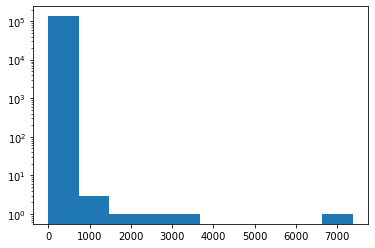

In [58]:
plt.hist(ak.flatten(pMom_isemc.pt))
plt.yscale("log")

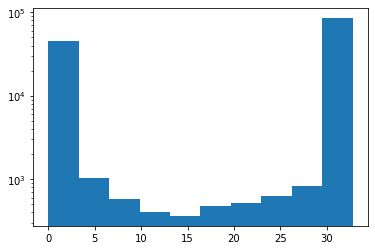

In [67]:
plt.hist(ak.flatten(track_emc_energy))
plt.yscale("log")

**Exercise 6:** The above plots throw out the list information, but it can be useful. How would you change the expression above to plot maximum calorimeter energy per event? What about the mean energy per event?

How do the shapes differ? (Make two Jupyter cells to compare them.)

See the NumPy [np.max](https://numpy.org/doc/stable/reference/generated/numpy.amax.html) and [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) documentation, and check for arguments that might help.

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Replace `ak.flatten` with `np.max` (`np.amax`) and `np.mean`, but it becomes necessary to supply the `axis=1` argument.

```python
plt.hist(np.max(track_emc_energy, axis=1))
plt.yscale("log")
```
<br>

The default `axis` for `ak.flatten` is already `axis=1`, but the default for `np.max` and `np.mean` is `axis=None`.

For all of these functions (and other reducers like `np.max` and `np.mean`, such as count, count_nonzero, sum, argmax, any, all...), `axis=1` eliminates the second dimension, but `axis=None` eliminates all dimensions. For flattening, `axis=None` returns a one-dimensional array, but for reducers, `axis=None` returns a scalar, which can't be plotted.

</details>

### Plotting the relationship between track $p_T$ and calorimeter $E$

Although [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) (and [plt.hist2d](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html)) can make a quick plot, you'll eventually want histogram _objects_ that are created with a specified binning and then filled (e.g. to fill iteratively or in parallel).

This is what the hist library provides, and it also has some [good 2D plotting routines](https://boost-histogram.readthedocs.io/en/latest/usage/numpy.html).

In [83]:
import hist

In [112]:
energy_vs_pt = hist.Hist(
    hist.axis.Regular(25, 5, 30, label="track pT"),
    hist.axis.Regular(25, 5, 30, label="calorimeter energy"),
)

In [113]:
energy_vs_pt.fill(ak.flatten(pMom_isemc.pt), ak.flatten(track_emc_energy))

Hist(
  Regular(25, 5, 30, label='track pT'),
  Regular(25, 5, 30, label='calorimeter energy'),
  storage=Double()) # Sum: 1326.0 (134626.0 with flow)

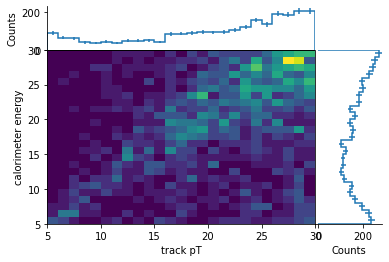

In [114]:
energy_vs_pt.plot2d_full();

**Exercise 7:** Fill this histogram. Why do you see warning messages?

In [132]:
ratio_vs_pt = hist.Hist(
    hist.axis.Regular(25, 5, 30, label="track pT"),
    hist.axis.Regular(20, 0, 2, label="track pT / calorimeter energy"),
)

In [ ]:
pt_over_energy_ratio = ???

In [136]:
ratio_vs_pt.fill(ak.flatten(pMom_isemc.pt), ak.flatten(pt_over_energy_ratio))

Hist(
  Regular(25, 5, 30, label='track pT'),
  Regular(20, 0, 2, label='track pT / calorimeter energy'),
  storage=Double()) # Sum: 1954.0 (134626.0 with flow)

Also, plot this ratio in one dimension:

In [148]:
pt_over_energy_ratio_plot = hist.Hist(hist.axis.Regular(40, 0, 4)).fill(ak.flatten(pt_over_energy_ratio))
pt_over_energy_ratio_plot[1:]

Hist(Regular(39, 0.1, 4, label='Axis 0'), storage=Double()) # Sum: 10177.0 (134626.0 with flow)

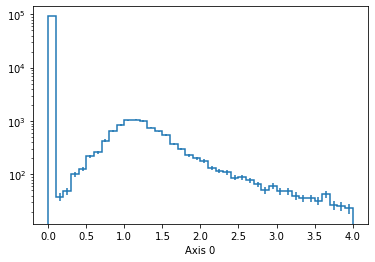

In [147]:
pt_over_energy_ratio_plot.plot()
plt.yscale("log")

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Divide the two quantities elementwise:

```python
pt_over_energy_ratio = pMom_isemc.pt / track_emc_energy
```
<br>

NumPy raises warnings about division by zero and zero-divided-by-zero (separately). That's sometimes a mistake, though in this case, we _know_ that some of the $p_T$ and $E$ values are zero. These warnings can be selectively ignored with [np.errstate](https://numpy.org/doc/stable/reference/generated/numpy.errstate.html).

Although division by zero would raise an exception in Python (stopping a script), they result in "not a number" in arrays. You can see them if you look at `pt_over_energy_ratio`.

```
<Array [[nan, nan, 0.471, ... nan, 4.32, nan]] type='8004 * var * float64'>
```
</details>

### Selecting electrons with $p_T/E$

Electrons deposit nearly all of their energy in the calorimeter, so $p_T/E$ is nearly 1. (Why $p_T/E$ and not track energy $/$ calorimeter energy? I personally don't know this bit of STAR detector physics.)

Looking at the one-dimensional ratio plot, what would be a good cut around the peak at 1?

**Exercise 8:** Suppose we take the cut to be 2/3 through 4/3. How do you make an array of 

In [ ]:
pMom_electrons = ???

In [158]:
pMom_electrons = pMom_isemc[(2/3 < pt_over_energy_ratio) & (pt_over_energy_ratio < 4/3)]

In [159]:
pMom_electrons

<MomentumArray4D [[], [{px: 34.7, ... M: 0.000511}]] type='8004 * var * Momentum...'>

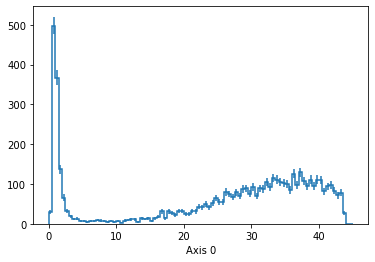

In [167]:
hist.Hist(hist.axis.Regular(90, 0, 45)).fill(ak.flatten(pMom_electrons.pt)).plot();

In [168]:
30 * 4/3

40.0